# Tree based models

Lecture 2.

In [9]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [10]:
from sklearn.datasets import make_blobs

labels = ["b", "r"]
X, y = make_blobs(n_samples=400, centers=23, random_state=42)
y = np.take(labels, (y < 10))

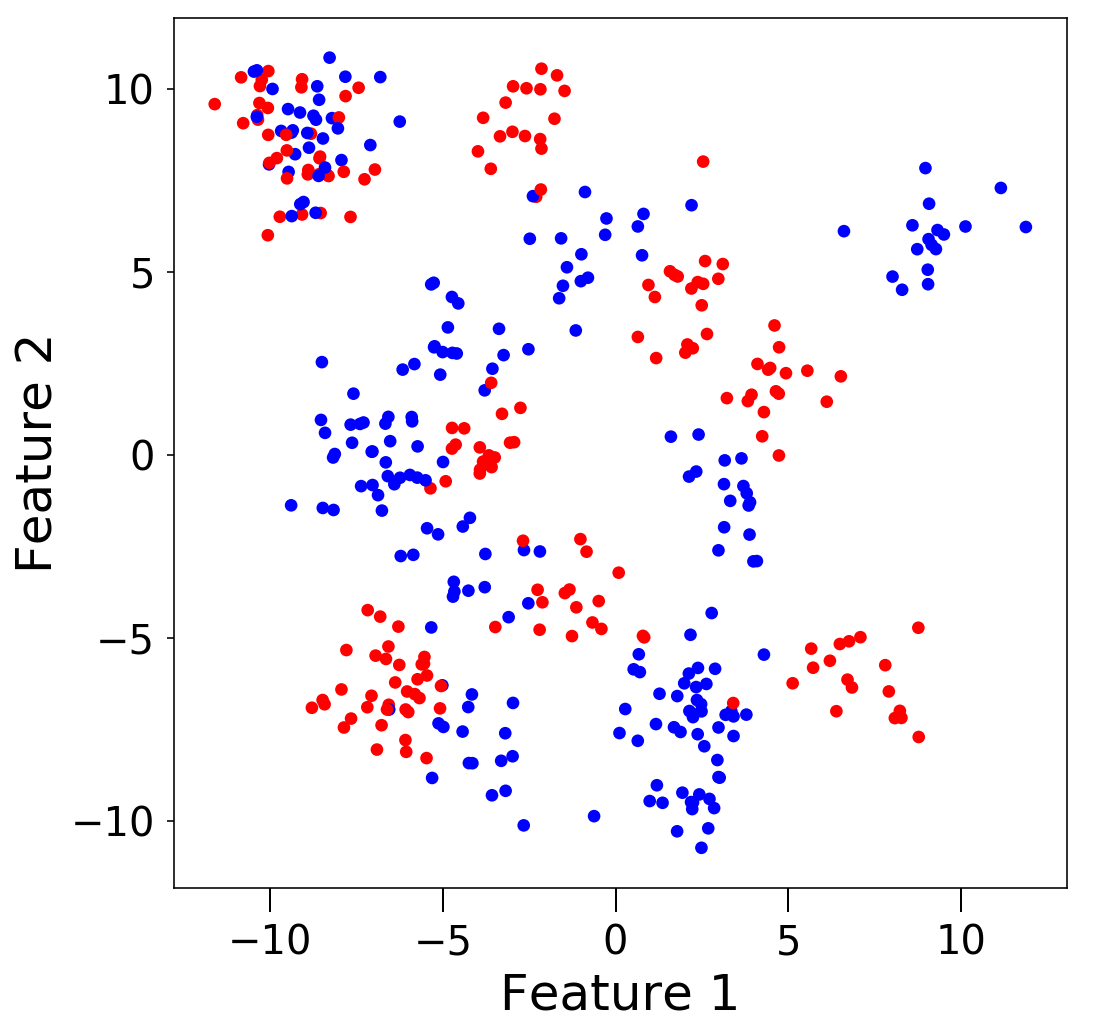

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, lw=0, s=40)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

## Decision trees

In [5]:
from ipywidgets import interact

from sklearn.tree import DecisionTreeClassifier

from utils import plot_surface


def tree(max_depth=1):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=1)
    clf.fit(X, y)
    plot_surface(clf, X, y)
    
interact(tree, max_depth=(1, 25))

<function __main__.tree>

In [6]:
# add an uninformative variable
X_uninformative = np.c_[X, np.random.randn(X.shape[0])]
print(X_uninformative)

[[ -4.21978613  -1.71762081  -1.0856306 ]
 [ -8.90204992   7.78548117   0.99734545]
 [ -2.58120774  10.01781903   0.2829785 ]
 ..., 
 [  2.33647511  -0.45368603   0.24537941]
 [ -9.38239529   6.52544711  -0.16842643]
 [  9.0668976    5.89522339   0.24402694]]


In [15]:
from utils import draw_tree

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_uninformative, y)
draw_tree(clf, ['X1', 'X2', 'X3'], filled=True)

## Forests

Random forests use bootstrapped samples and randomly select $n \leq p$ features to split on.

Extra trees use randomly select $n \leq p$ features to split on and pick split point at random.

In [14]:
from sklearn.ensemble import RandomForestRegressor

from utils import load_wine


X, y = load_wine()

clf = RandomForestRegressor()
clf.fit(X[3:], y[3:]) # all but first three samples

FileNotFoundError: [Errno 2] No such file or directory: '../data/winequality-red.csv'

In [8]:
for n, tree in enumerate(clf.estimators_):
    print("Prediction by tree %i" % n, tree.predict(X[:3,:]))
    
print("Prediction by forest", clf.predict(X[:3,:]))
print("         True labels", y[:3])

Prediction by tree 0 [ 5.  5.  5.]
Prediction by tree 1 [ 5.  4.  5.]
Prediction by tree 2 [ 5.  5.  5.]
Prediction by tree 3 [ 5.  5.  5.]
Prediction by tree 4 [ 5.  5.  6.]
Prediction by tree 5 [ 5.  5.  6.]
Prediction by tree 6 [ 5.  5.  5.]
Prediction by tree 7 [ 5.  6.  5.]
Prediction by tree 8 [ 5.  5.  6.]
Prediction by tree 9 [ 5.  5.  5.]
Prediction by forest [ 5.   5.   5.3]
         True labels [ 5.  5.  5.]


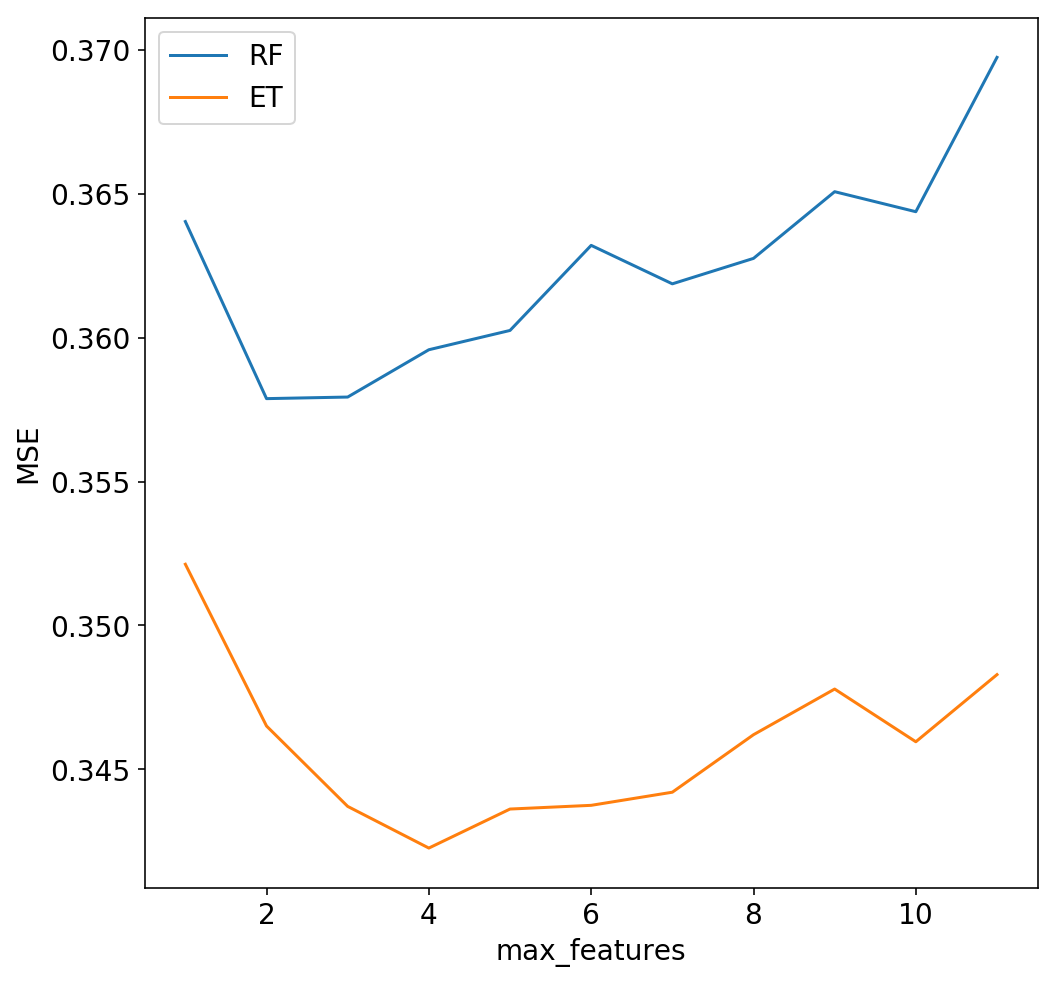

In [9]:
# controlling amount of randomisation by setting max_features
# for both extra trees and random forests
#
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import ExtraTreesRegressor


param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#XXX="""
cv = StratifiedKFold(n_splits=5, shuffle=True)

_, test_scores = validation_curve(RandomForestRegressor(n_estimators=100, n_jobs=-1),
                                  X, y, cv=cv,
                                  param_name='max_features', param_range=param_range,
                                  scoring='neg_mean_squared_error')
test_scores = -np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores, label='RF')

_, test_scores = validation_curve(ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
                                  X, y, cv=cv,
                                  param_name='max_features', param_range=param_range,
                                  scoring='neg_mean_squared_error')
test_scores = -np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores, label="ET")
plt.xlabel("max_features")
plt.ylabel("MSE")
plt.legend(loc='best');
#"""

---

### Aside, classification

Individual trees output the class index, `RandomForestClassifier` has already
translated back to class label. This is a bit confusing.

In [10]:
from sklearn.ensemble import RandomForestClassifier

from utils import load_wine


X, y = load_wine()

clf = RandomForestClassifier()
clf.fit(X[3:], y[3:])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [11]:
for n, tree in enumerate(clf.estimators_):
    print("Prediction by tree %i" % n, tree.predict(X[:3,:]))
    
print("Prediction by forest", clf.predict(X[:3,:]))

Prediction by tree 0 [ 2.  2.  2.]
Prediction by tree 1 [ 2.  3.  3.]
Prediction by tree 2 [ 2.  2.  2.]
Prediction by tree 3 [ 2.  2.  1.]
Prediction by tree 4 [ 2.  2.  0.]
Prediction by tree 5 [ 2.  2.  3.]
Prediction by tree 6 [ 2.  2.  3.]
Prediction by tree 7 [ 2.  2.  3.]
Prediction by tree 8 [ 2.  3.  2.]
Prediction by tree 9 [ 2.  2.  2.]
Prediction by forest [ 5.  5.  5.]


In [12]:
clf.classes_[2]

5.0

---

## Adaboost illustrated

In [13]:
labels = ["b", "r"]
X, y = make_blobs(n_samples=400, centers=23, random_state=42)
y = np.take(labels, (y < 10))

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=50, algorithm="SAMME",
                         base_estimator=DecisionTreeClassifier(max_depth=3))
clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

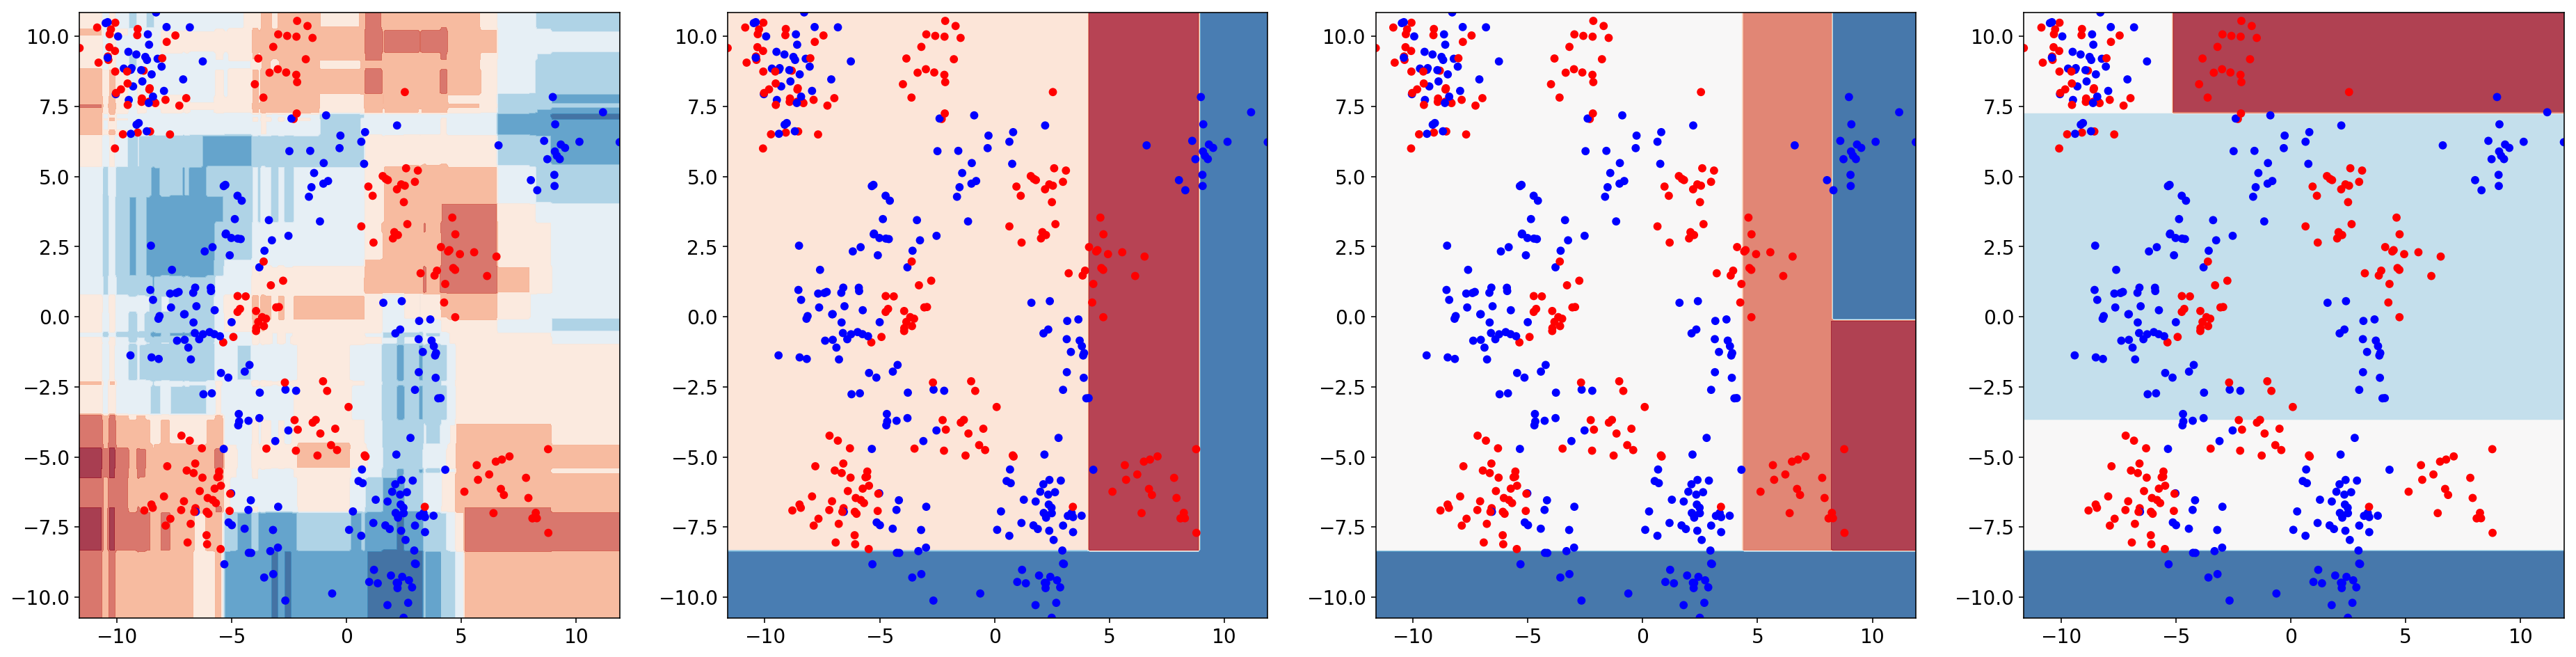

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(4*8, 8))

plot_surface(clf, X, y, ax=axs[0], show=False)

for n, ax, est in zip(range(3), axs[1:], clf.estimators_):
    plot_surface(est, X, y, ax=ax, show=False)

---

## Gradient boosting illustrated

In [15]:
def f(x):
    return x + np.sin(x) + np.sin(3 * x)

line = np.linspace(0, 10, 200)
x = np.linspace(0, 10, 200)
rng = np.random.RandomState(0)
rng.shuffle(x)
X = np.sort(x[:40])
y = f(X)

X = X.reshape(-1, 1)

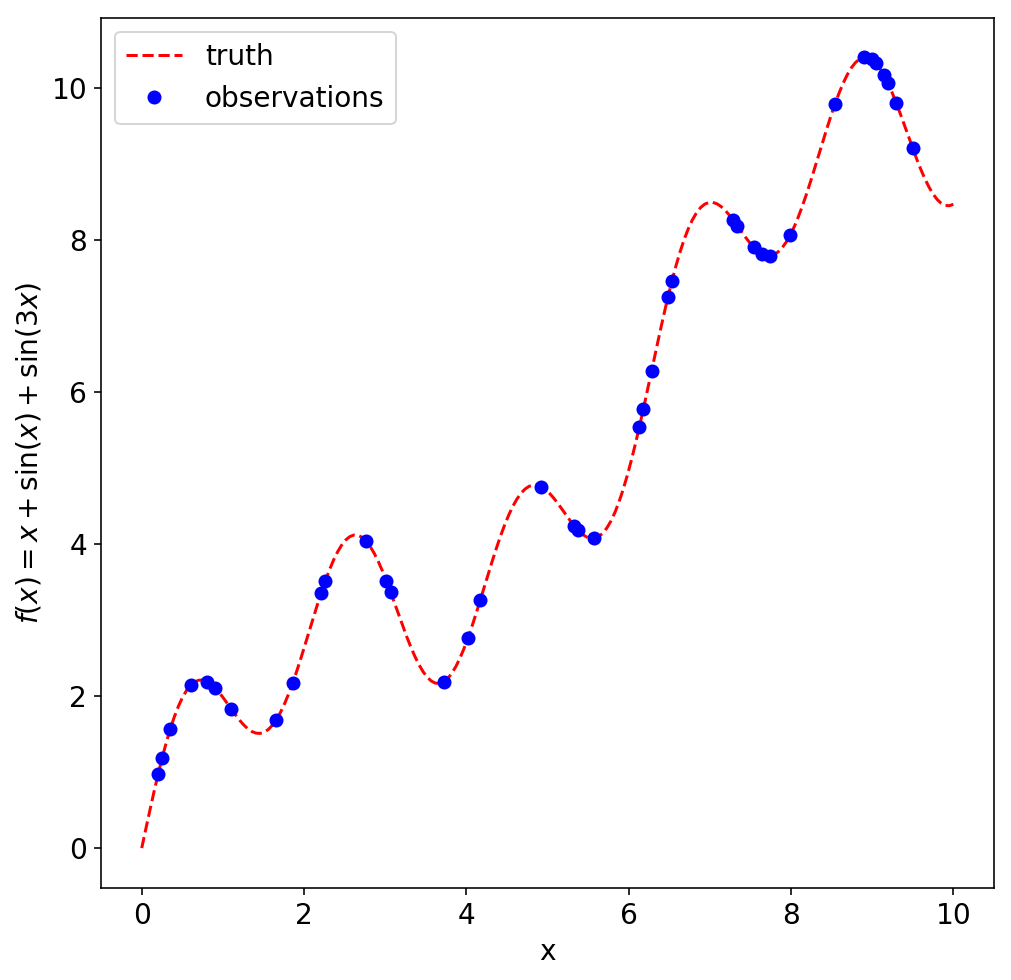

In [16]:
plt.plot(line, f(line), '--r', label='truth')
plt.plot(X, y, 'ob', label='observations')
plt.xlabel('x')
plt.ylabel('$f(x)=x+\sin(x)+\sin(3x)$')
plt.legend(loc='best');

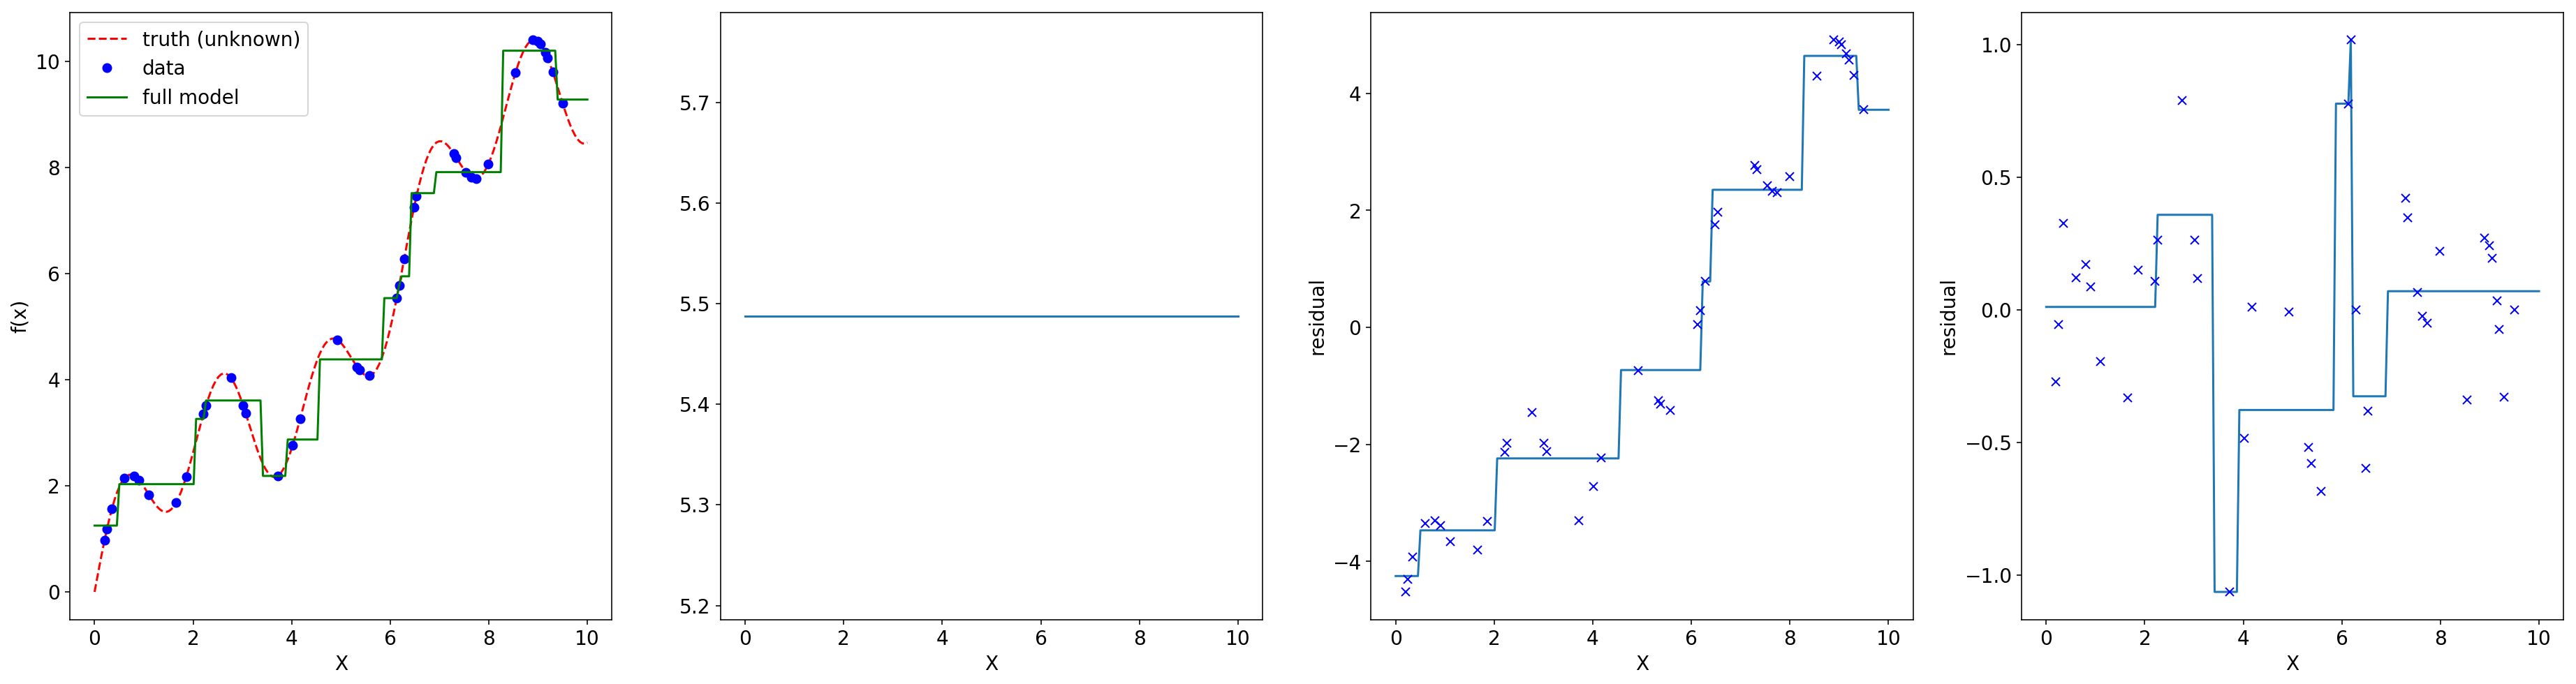

In [17]:
from sklearn.ensemble import GradientBoostingRegressor


rgr = GradientBoostingRegressor(n_estimators=2, learning_rate=1)
rgr.fit(X, y)

fig, axs = plt.subplots(1, 5-1, figsize=(4*8, 8))

# original data and full model
ax = axs[0]
ax.plot(line, f(line), '--r', label='truth (unknown)')
ax.plot(X, y, 'ob', label='data')
ax.plot(line, rgr.predict(line.reshape(-1, 1)), '-g', label='full model')
ax.set_ylabel('f(x)')
ax.set_xlabel("X")
ax.legend(loc='best')

# "random" initialisation
prev_prediction = np.ones_like(y) * np.mean(y)
ax = axs[1]
ax.plot([0, 10], prev_prediction[0:2])
ax.set_xlabel("X")

# "boosts" or gradient steps
for n, ((est,), ax) in enumerate(zip(rgr.estimators_, axs[2:])):
    ax.plot(line, est.predict(line.reshape(-1, 1)))
    ax.plot(X, y - prev_prediction, 'xb')
    prev_prediction += est.predict(X)
    ax.set_xlabel("X")
    ax.set_ylabel("residual")

---

## Practicalities of gradient boosting

Shrinkage, or `learning_rate`.

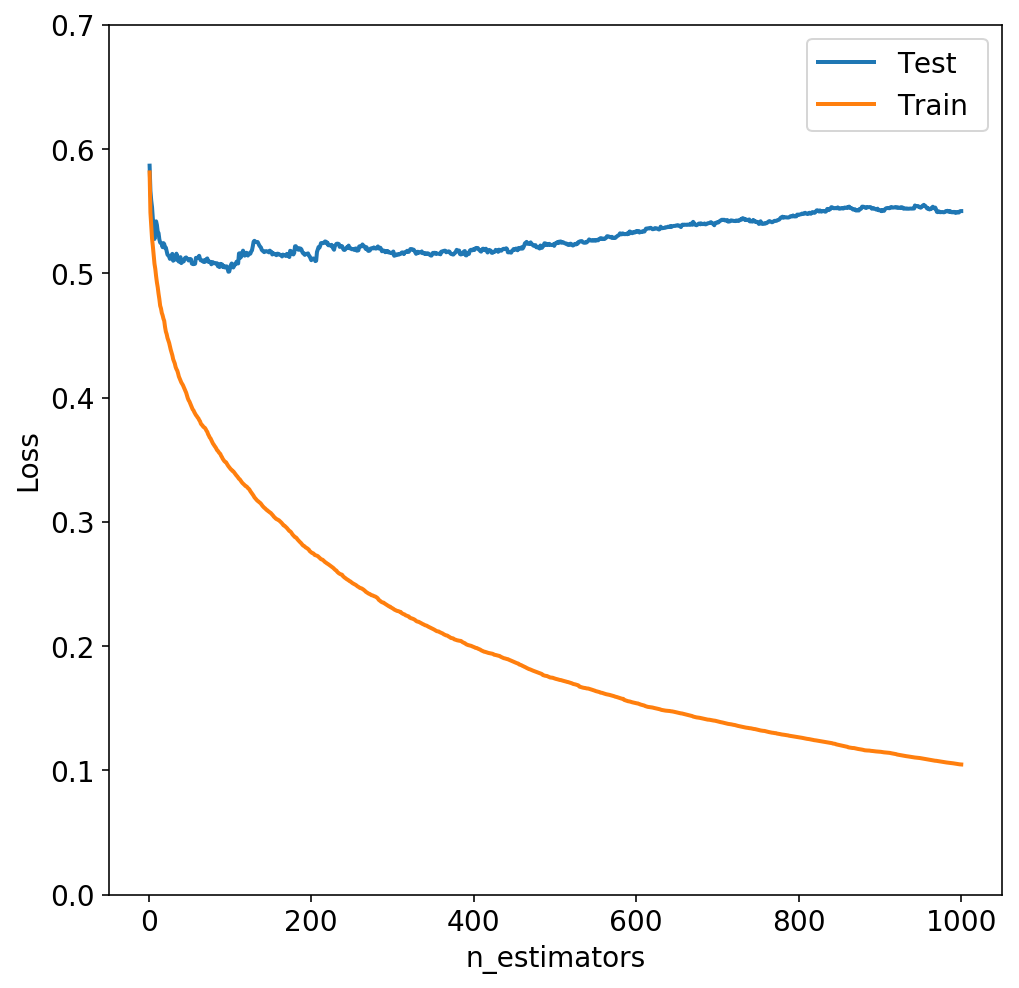

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from utils import plot_loss

X, y = load_wine()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = GradientBoostingRegressor(n_estimators=1000, max_depth=2, learning_rate=1.)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test)
ax.legend(loc='best')

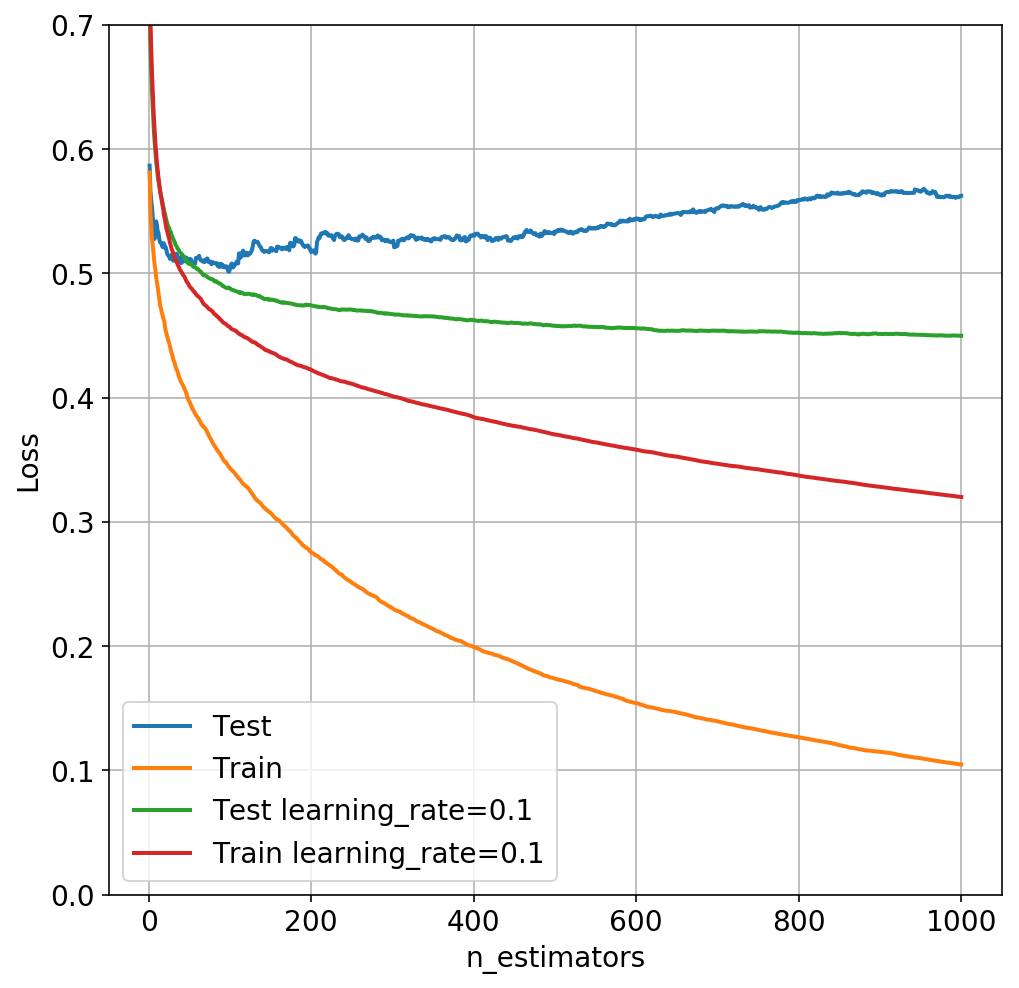

In [19]:
# shrinkage
# Slow learning by shrinking the predictions of each tree by some small scalar (learning_rate)
# A lower learning_rate requires a higher number of n_estimators

ax = plt.gca()

clf = GradientBoostingRegressor(n_estimators=1000, max_depth=2, learning_rate=1.)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test, ax=ax)


clf = GradientBoostingRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test, ax=ax, label='learning_rate=0.1')
ax.legend(loc='best')
ax.grid()

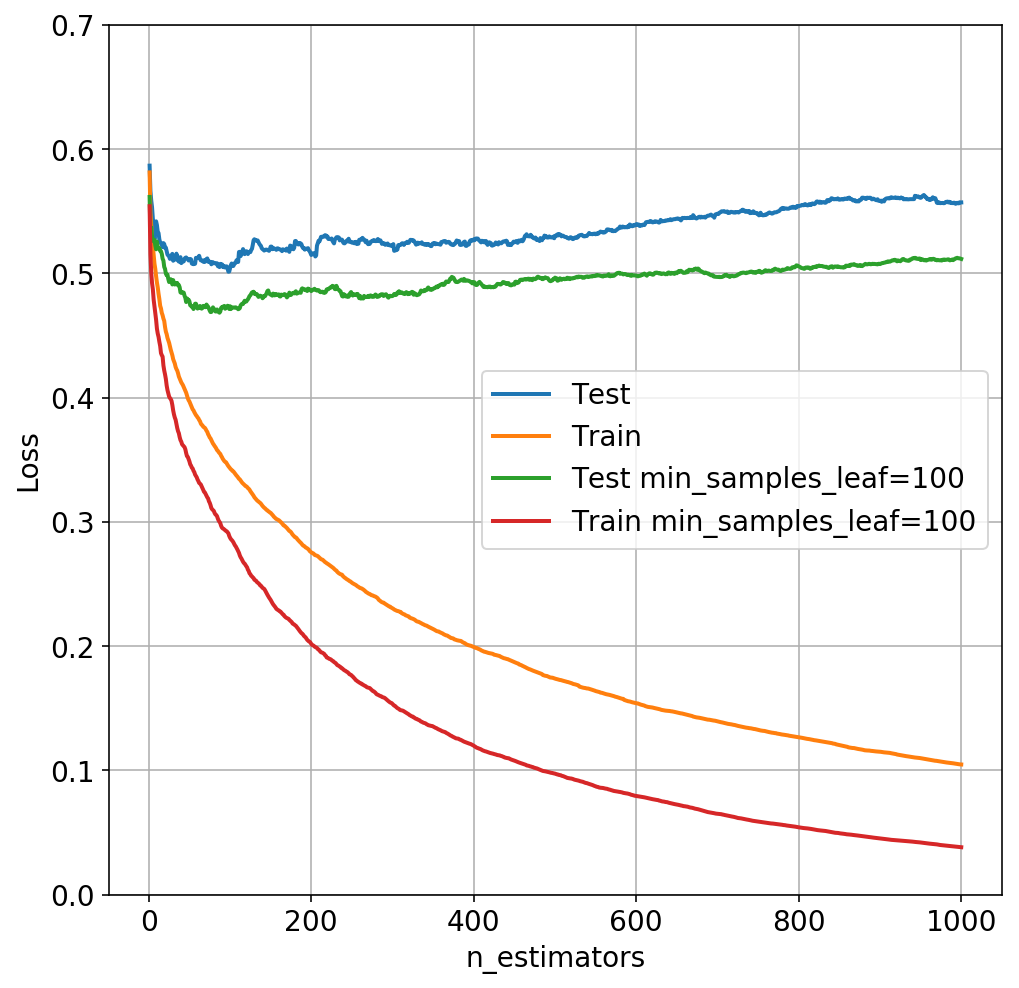

In [20]:
# The max_depth of the trees controls the degree of to which features interact (variance++)
# Use min_samples_leaf to have a sufficient number of samples per leaf (bias++)

ax = plt.gca()

clf = GradientBoostingRegressor(n_estimators=1000, max_depth=2, learning_rate=1.)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test, ax=ax)


clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=1., min_samples_leaf=100)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test, ax=ax,
                  label='min_samples_leaf=100')
ax.legend(loc='best')
ax.grid()

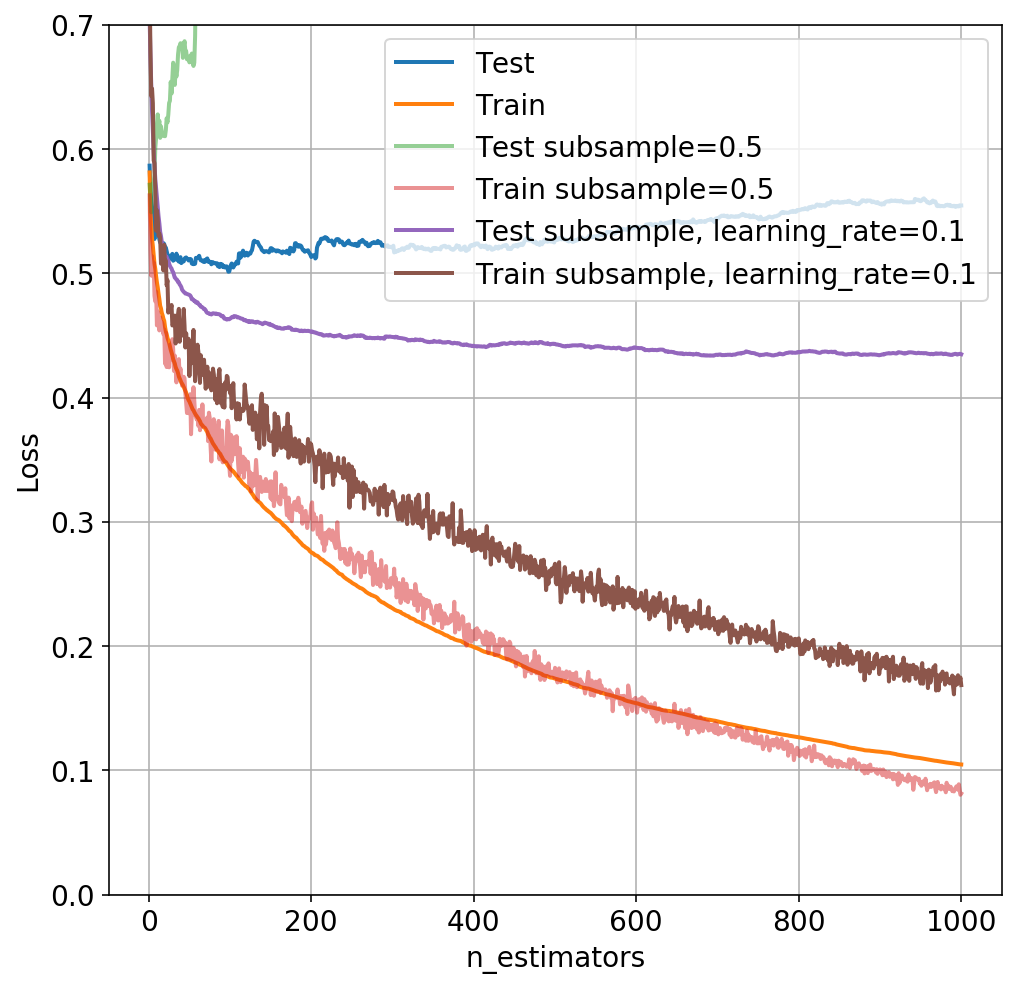

In [21]:
# Stochastic gradient descent
# Subsampling the training set before growing each tree (subsample)
# Subsampling the features before finding the best split node (max_features)
# Latter usually works better if there is a sufficient large number of features

ax = plt.gca()

clf = GradientBoostingRegressor(n_estimators=1000, max_depth=2, learning_rate=1.)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test, ax=ax)


clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=1., subsample=0.5)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test, ax=ax, alpha=0.5, label='subsample=0.5')

clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, subsample=0.5)
clf.fit(X_train, y_train)

_, ax = plot_loss(clf, X_test, y_test, ax=ax, label='subsample, learning_rate=0.1')

ax.legend(loc='best')
ax.grid()

---

## Feature importances

In [22]:
feature_names = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar",
                 "chlorides", "free sulfur dioxide", "total sulfur dioxide",
                 "density", "pH", "sulphates", "alcohol"]
clf.feature_importances_

array([ 0.08248489,  0.08621406,  0.06207913,  0.10862872,  0.08892487,
        0.08773092,  0.10734443,  0.11229721,  0.09335184,  0.08482919,
        0.08611472])

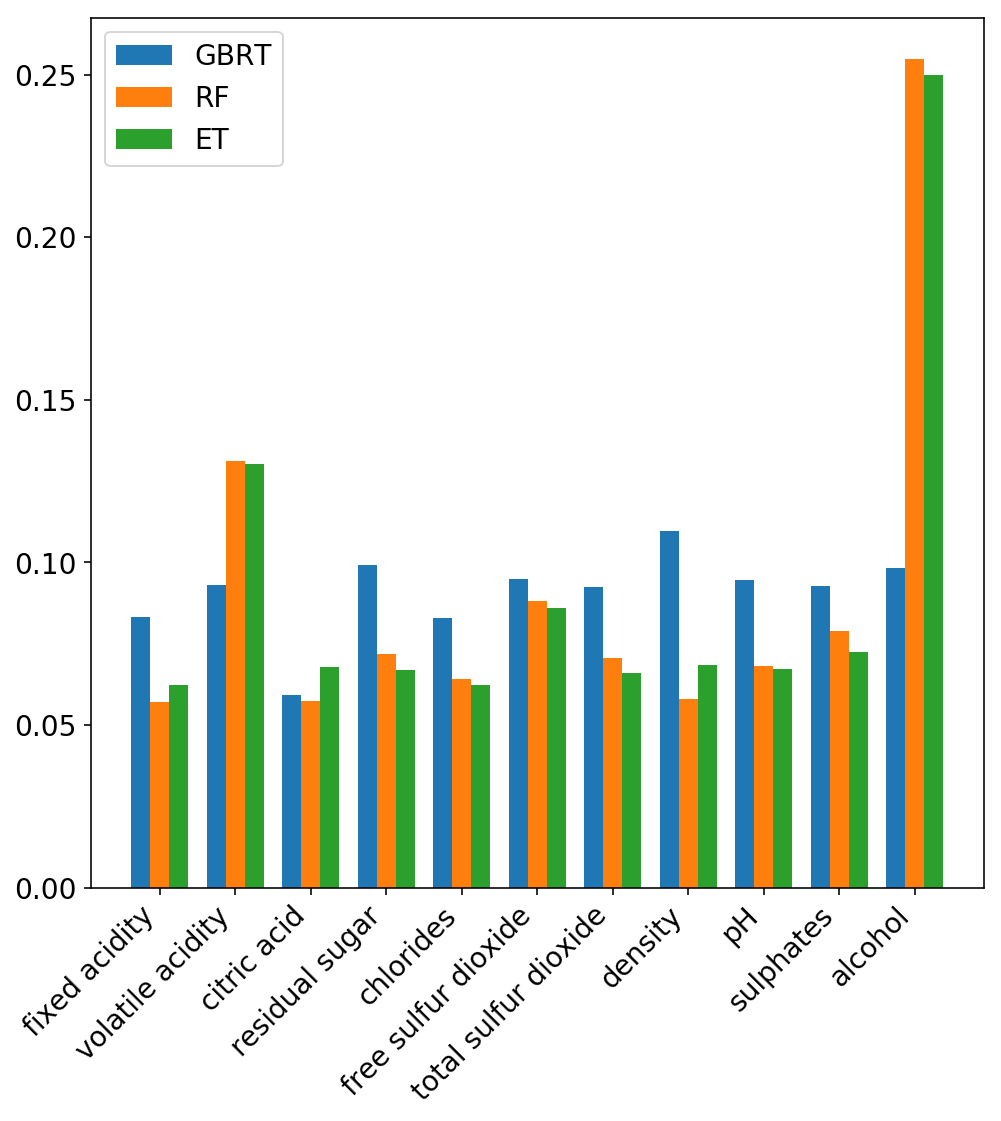

In [23]:
index = np.arange(len(feature_names))
bar_width = 0.25

gbrt = GradientBoostingRegressor(n_estimators=1000, max_depth=2,
                                 learning_rate=0.1, subsample=0.5)
gbrt.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

et = ExtraTreesRegressor(n_estimators=200)
et.fit(X_train, y_train)


plt.bar(index - bar_width, gbrt.feature_importances_, bar_width, label='GBRT')
plt.bar(index, rf.feature_importances_, bar_width, label='RF')
plt.bar(index + bar_width, et.feature_importances_, bar_width, label='ET')

plt.legend(loc='best')
plt.xticks(index, feature_names, rotation=45, horizontalalignment="right");

---

## Partial dependence plots

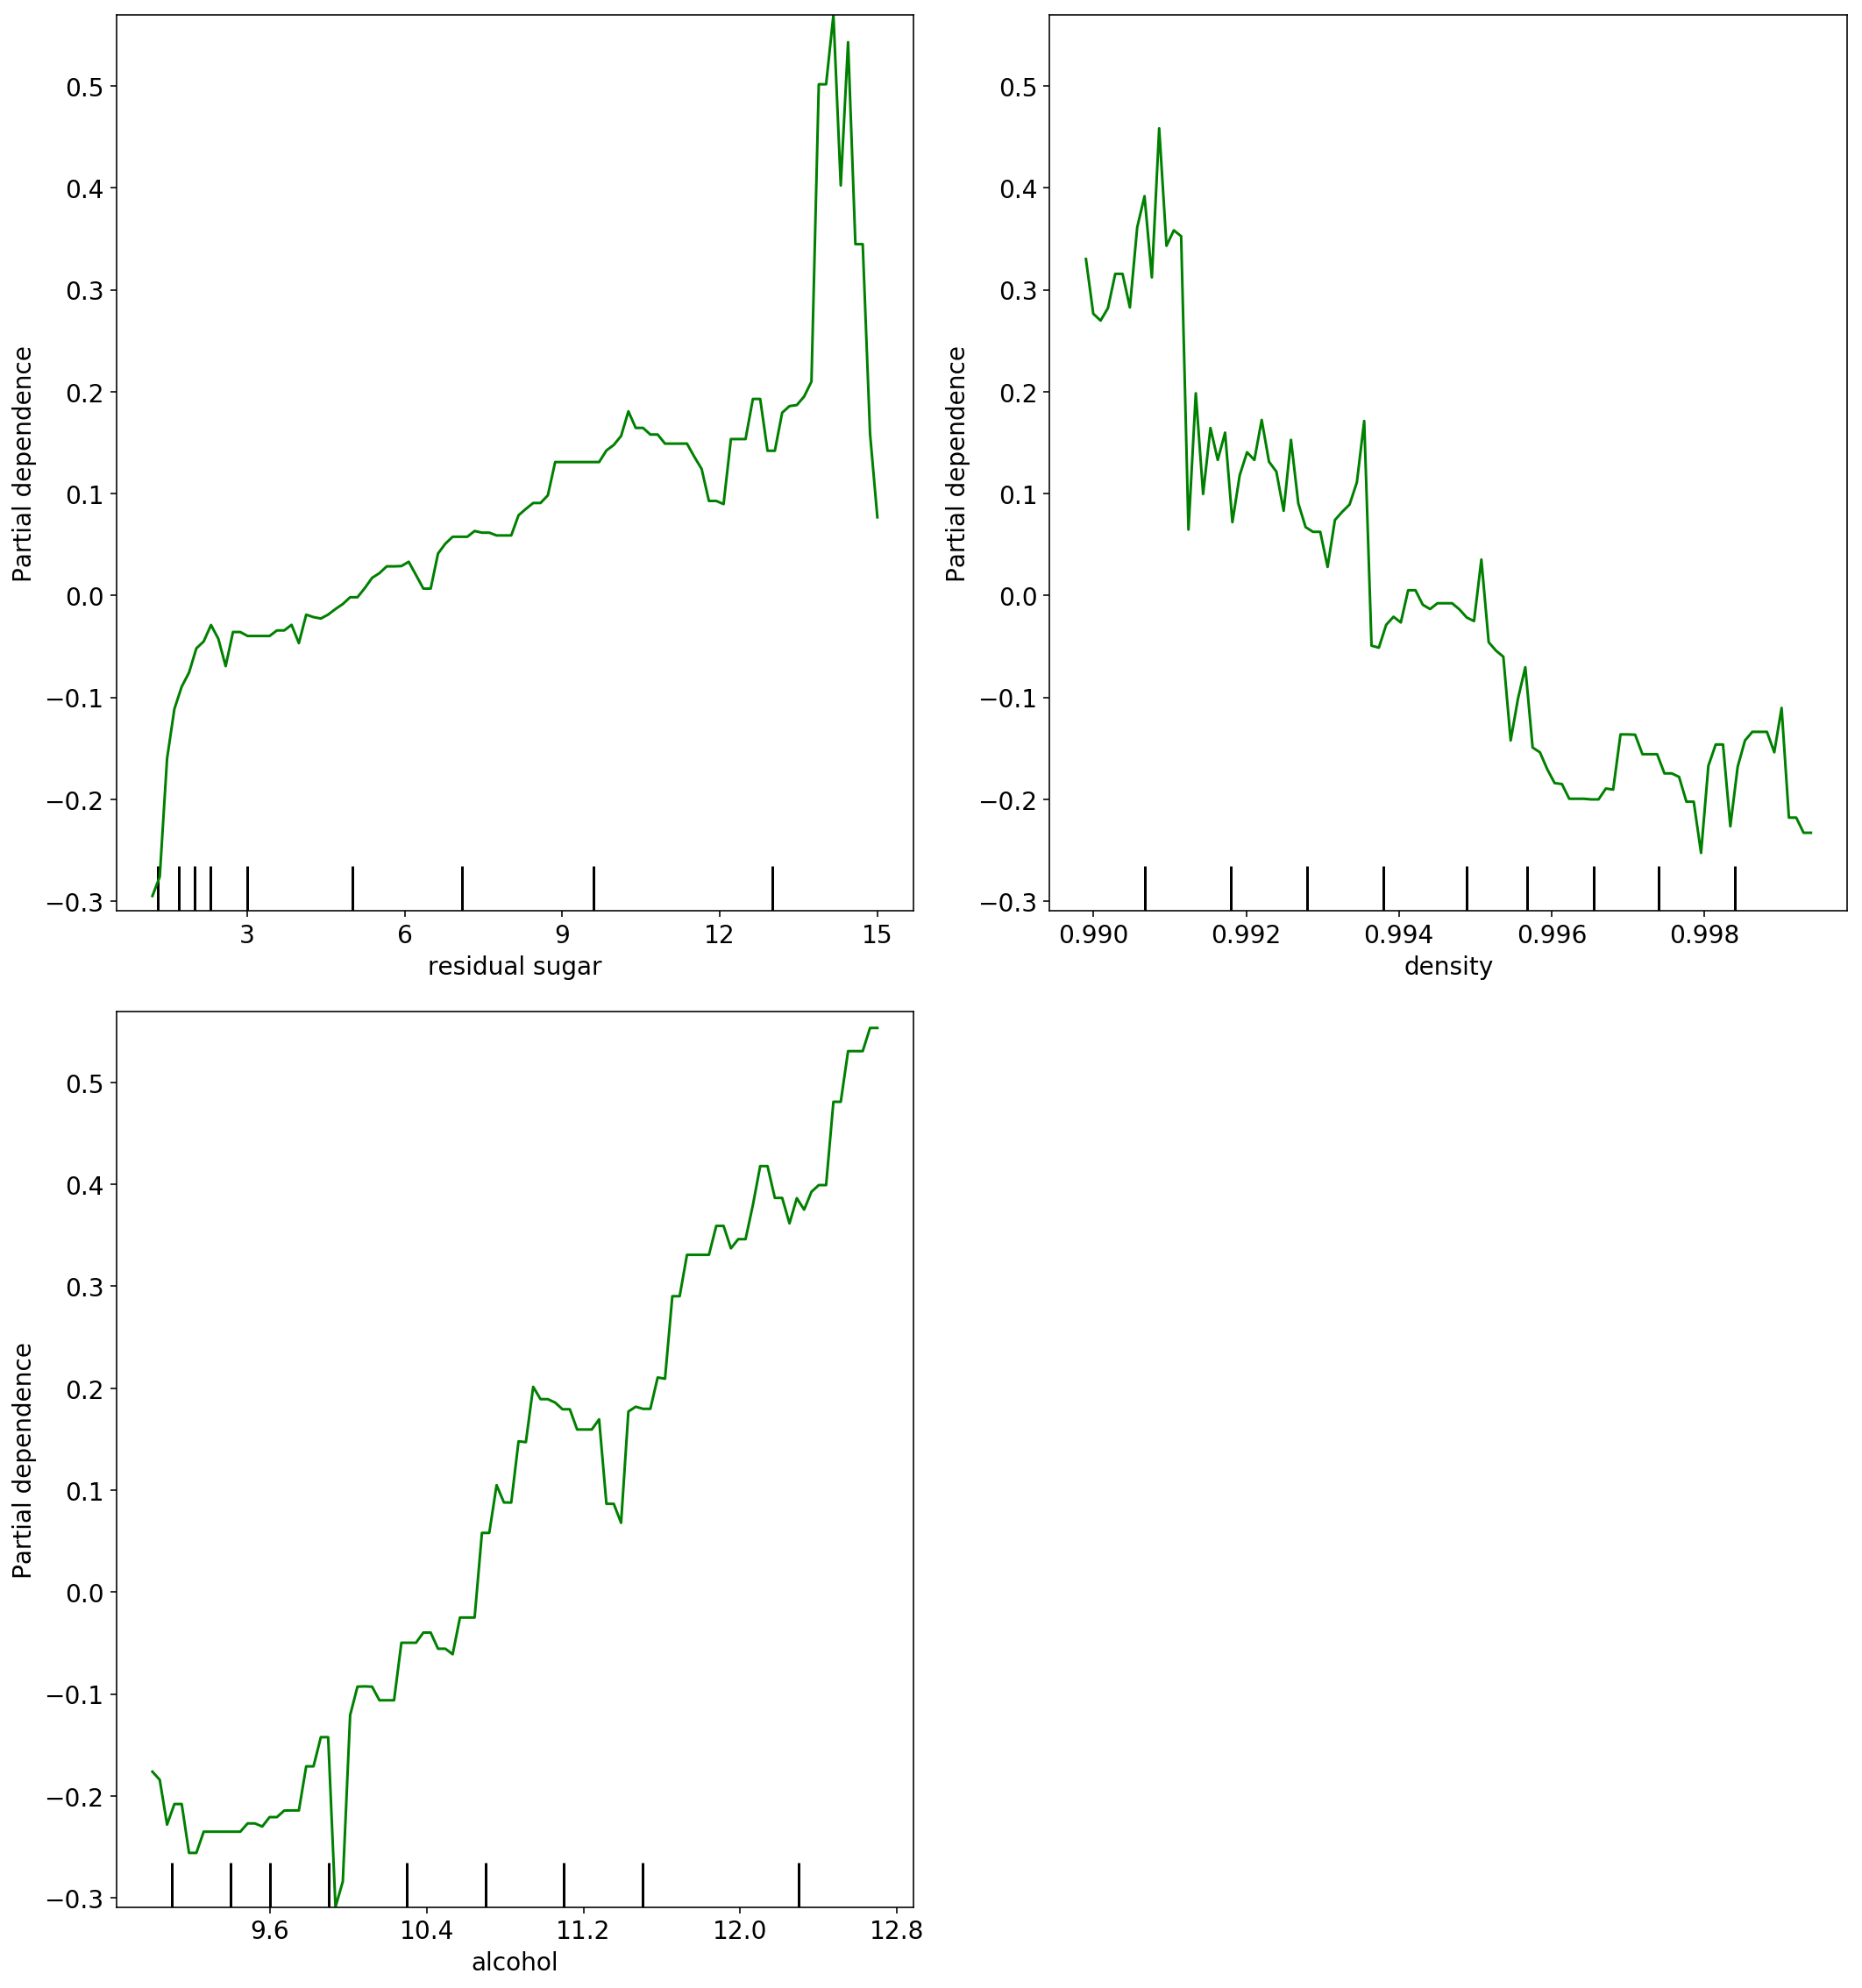

In [24]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plot_partial_dependence(gbrt, X, features=[3, 7, 10], feature_names=feature_names,
                        figsize=(15,16), n_cols=2);
plt.tight_layout();